# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_169  G3V533;Q6ZMZ3;Q6ZMZ3-2;Q6ZMZ3-3   15.324
Sample_207  P04114                            15.537
Sample_001  A0A087WWT2;Q9NPD7                 17.806
Sample_199  P16152                            16.162
Sample_086  O43157                            15.592
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups
Sample_200  Q96GW7           20.164
Sample_169  Q9NUQ9           12.840
Sample_200  Q6UWR7           14.897
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.584
            A0A075B6Q5                 12.407
            A0A075B6R2                 14.847
            A0A075B6S5                 13.593
            A0A087WSY4                 12.576
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.302
            Q9UI40;Q9UI40-2            12.703
            Q9UIW2                     12.997
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.912
            Q9UP79                     13.572
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.088,15.050,16.842,19.863,15.902,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.626,19.067,...,15.528,15.576,14.016,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.733,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.526,17.705,17.039,16.090,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.815,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.415,15.345,17.084,18.708,14.249,19.433,12.299,11.020
Sample_207,15.739,16.877,15.469,16.898,15.003,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.379,13.086,13.946,12.301,12.528,12.673,13.810,12.763,13.000,12.338
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.165,19.067,16.127,...,11.991,12.913,14.294,14.303,12.616,13.124,12.410,13.359,11.672,12.614
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,10.844,13.189,11.206,13.089,11.973,12.942,12.020,13.419,13.570,13.630
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.769,12.975,12.364,12.323,13.083,12.159,12.487,13.444,13.086,13.039
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.917,11.957,13.374,12.616,13.528,12.950,13.939,12.371,13.507,11.838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.076,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 354.55it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.55it/s]

100%|██████████| 2/2 [00:00<00:00,  7.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.08it/s]

100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.38it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.41it/s]

100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.42it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.38it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.53it/s]

100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

100%|██████████| 5/5 [00:01<00:00,  4.55it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.31it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.32it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.89it/s]

100%|██████████| 6/6 [00:01<00:00,  4.33it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.12it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.54it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.62it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.19it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.80it/s]

100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.01it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.86it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.40it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.04it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.01it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.84it/s]

100%|██████████| 8/8 [00:01<00:00,  3.77it/s]

100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.57it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.40it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.86it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.29it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.01it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.85it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.95it/s]

100%|██████████| 9/9 [00:02<00:00,  3.80it/s]

100%|██████████| 9/9 [00:02<00:00,  4.21it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.72it/s]

 30%|███       | 3/10 [00:00<00:01,  4.76it/s]

 40%|████      | 4/10 [00:00<00:01,  4.47it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.23it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.26it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.99it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.96it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.73it/s]

100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.56it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.84it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.61it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.25it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.03it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.04it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.08it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.09it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.01it/s]

100%|██████████| 11/11 [00:02<00:00,  3.96it/s]

100%|██████████| 11/11 [00:02<00:00,  4.17it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.89it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.41it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.15it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.11it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.98it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.72it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.82it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.76it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.69it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.85it/s]

100%|██████████| 12/12 [00:02<00:00,  4.00it/s]

100%|██████████| 12/12 [00:02<00:00,  4.00it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.48it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.60it/s]

 31%|███       | 4/13 [00:01<00:02,  3.36it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.89it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.89it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.79it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.74it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.75it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.85it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.74it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.78it/s]

100%|██████████| 13/13 [00:04<00:00,  2.87it/s]

100%|██████████| 13/13 [00:04<00:00,  2.93it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.94it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.81it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.32it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.42it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.57it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.73it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.77it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.59it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.56it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.56it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.59it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.61it/s]

100%|██████████| 14/14 [00:03<00:00,  3.29it/s]

100%|██████████| 14/14 [00:03<00:00,  3.54it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.92it/s]

 20%|██        | 3/15 [00:00<00:03,  3.34it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.80it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.52it/s]

 40%|████      | 6/15 [00:02<00:03,  2.48it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.66it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.85it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.95it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.23it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.35it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.15it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.23it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.31it/s]

100%|██████████| 15/15 [00:04<00:00,  3.36it/s]

100%|██████████| 15/15 [00:04<00:00,  3.09it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.035 0.008          0.669 0.414       0.086   
2             0.003 0.000      0.035 0.001          0.696 0.131       0.528   
3             0.003 0.000      0.036 0.005          0.700 0.121       0.619   
4             0.003 0.000      0.036 0.005          0.709 0.110       0.624   
5             0.003 0.000      0.036 0.006          0.687 0.092       0.666   
6             0.003 0.000      0.034 0.003          0.802 0.081       0.805   
7             0.003 0.000      0.036 0.005          0.795 0.082       0.801   
8             0.003 0.000      0.036 0.006          0.793 0.089       0.787   
9             0.004 0.004      0.035 0.006          0.790 0.091       0.791   
10            0.003 0.000      0.030 0.003          0.792 0.089       0.788   
11            0.004 0.002      0.036 0.005          0.794 0.086       0.798   
12            0.003 0.000      0.032 0.007          0.813 0.088       0.804   
13            0.003 0.000      0.037 0.008          0.803 0.090       0.800   
14            0.005 0.005      0.048 0.022          0.798 0.093       0.795   
15            0.006 0.005      0.051 0.017          0.794 0.089       0.794   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.076   0.147 0.116                  0.536 0.035        0.844   
2          0.109   0.592 0.090                  0.675 0.065        0.721   
3          0.128   0.646 0.090                  0.705 0.071        0.780   
4          0.103   0.657 0.079                  0.714 0.063        0.802   
5          0.112   0.671 0.079                  0.720 0.065        0.798   
6          0.111   0.798 0.071                  0.828 0.058        0.891   
7          0.109   0.793 0.070                  0.824 0.058        0.888   
8          0.099   0.785 0.067                  0.816 0.056        0.887   
9          0.107   0.785 0.072                  0.816 0.060        0.887   
10         0.108   0.785 0.074                  0.816 0.062        0.889   
11         0.115   0.790 0.073                  0.821 0.061        0.896   
12         0.107   0.803 0.070                  0.832 0.058        0.905   
13         0.109   0.795 0.072                  0.826 0.059        0.904   
14         0.101   0.791 0.070                  0.821 0.058        0.903   
15         0.103   0.788 0.069                  0.819 0.058        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.820 0.089        210.000 0.000  
2          0.080                  0.686 0.098        210.000 0.000  
3          0.078                  0.714 0.097        210.000 0.000  
4          0.072                  0.762 0.094        210.000 0.000  
5          0.066                  0.755 0.092        210.000 0.000  
6          0.050                  0.860 0.063        210.000 0.000  
7          0.051                  0.858 0.064        210.000 0.000  
8          0.052                  0.855 0.067        210.000 0.000  
9          0.054                  0.858 0.065        210.000 0.000  
10         0.054                  0.864 0.064        210.000 0.000  
11         0.053                  0.879 0.057        210.000 0.000  
12         0.052                  0.893 0.052        210.000 0.000  
13         0.052                  0.892 0.053        210.000 0.000  
14         0.052                  0.891 0.052        210.000 0.000  
15         0.051                  0.891 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 478.75it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.22it/s]

100%|██████████| 3/3 [00:00<00:00,  2.94it/s]

100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.29it/s]

100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.53it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.08it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.52it/s]

100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.14it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.34it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.33it/s]

100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.90it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.48it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  3.00it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.95it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.00it/s]

100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

100%|██████████| 7/7 [00:02<00:00,  2.95it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.86it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.58it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.06it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.91it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.02it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.05it/s]

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.52it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.76it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.07it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.93it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.83it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.94it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.07it/s]

100%|██████████| 9/9 [00:02<00:00,  2.95it/s]

100%|██████████| 9/9 [00:02<00:00,  3.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.84it/s]

 30%|███       | 3/10 [00:00<00:02,  3.45it/s]

 40%|████      | 4/10 [00:01<00:01,  3.03it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.85it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.00it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.05it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.07it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.13it/s]

100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

100%|██████████| 10/10 [00:03<00:00,  3.17it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.36it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.47it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.87it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.64it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.57it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.79it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.91it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.94it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.90it/s]

100%|██████████| 11/11 [00:03<00:00,  3.06it/s]

100%|██████████| 11/11 [00:03<00:00,  2.99it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.02it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.06it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.69it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.43it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.54it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.78it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.95it/s]

 75%|███████▌  | 9/12 [00:03<00:00,  3.07it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.13it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.08it/s]

100%|██████████| 12/12 [00:04<00:00,  3.09it/s]

100%|██████████| 12/12 [00:04<00:00,  2.96it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.99it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.41it/s]

 31%|███       | 4/13 [00:00<00:02,  3.83it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.21it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.76it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.39it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.24it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.29it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.28it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.37it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.49it/s]

100%|██████████| 13/13 [00:04<00:00,  2.65it/s]

100%|██████████| 13/13 [00:04<00:00,  2.74it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.34it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.88it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.34it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.90it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.73it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.67it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.69it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.81it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.81it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.01it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.67it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.55it/s]

100%|██████████| 14/14 [00:04<00:00,  2.63it/s]

100%|██████████| 14/14 [00:04<00:00,  2.89it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.84it/s]

 20%|██        | 3/15 [00:00<00:03,  3.35it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.96it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.84it/s]

 40%|████      | 6/15 [00:02<00:03,  2.74it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.37it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.23it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.21it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.43it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.61it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.77it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.82it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.97it/s]

100%|██████████| 15/15 [00:05<00:00,  2.95it/s]

100%|██████████| 15/15 [00:05<00:00,  2.75it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.048 0.018          0.000 0.000       0.000   
2             0.004 0.002      0.043 0.015          0.689 0.171       0.360   
3             0.004 0.002      0.040 0.014          0.678 0.098       0.589   
4             0.004 0.003      0.045 0.018          0.706 0.100       0.638   
5             0.005 0.004      0.050 0.022          0.710 0.097       0.658   
6             0.005 0.004      0.048 0.021          0.746 0.104       0.674   
7             0.004 0.003      0.052 0.024          0.738 0.105       0.673   
8             0.006 0.005      0.051 0.024          0.746 0.099       0.676   
9             0.006 0.006      0.054 0.025          0.745 0.097       0.674   
10            0.005 0.004      0.052 0.023          0.748 0.098       0.677   
11            0.006 0.006      0.053 0.022          0.811 0.082       0.797   
12            0.005 0.004      0.053 0.020          0.808 0.085       0.794   
13            0.004 0.002      0.043 0.014          0.808 0.080       0.794   
14            0.005 0.003      0.051 0.022          0.807 0.082       0.783   
15            0.005 0.005      0.059 0.022          0.790 0.084       0.779   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.855   
2          0.135   0.454 0.118                  0.612 0.061        0.709   
3          0.102   0.626 0.086                  0.691 0.066        0.777   
4          0.121   0.664 0.095                  0.720 0.073        0.800   
5          0.123   0.677 0.093                  0.729 0.072        0.805   
6          0.108   0.702 0.086                  0.751 0.067        0.830   
7          0.107   0.698 0.086                  0.746 0.069        0.828   
8          0.121   0.704 0.096                  0.753 0.075        0.832   
9          0.120   0.702 0.094                  0.752 0.072        0.829   
10         0.124   0.705 0.094                  0.754 0.072        0.827   
11         0.106   0.799 0.070                  0.829 0.057        0.907   
12         0.103   0.796 0.070                  0.827 0.057        0.906   
13         0.106   0.796 0.070                  0.827 0.058        0.905   
14         0.105   0.790 0.070                  0.822 0.058        0.906   
15         0.108   0.779 0.072                  0.812 0.059        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.826 0.085        210.000 0.000  
2          0.076                  0.636 0.101        210.000 0.000  
3          0.069                  0.719 0.097        210.000 0.000  
4          0.067                  0.765 0.088        210.000 0.000  
5          0.067                  0.766 0.091        210.000 0.000  
6          0.062                  0.792 0.082        210.000 0.000  
7          0.061                  0.785 0.084        210.000 0.000  
8          0.064                  0.799 0.080        210.000 0.000  
9          0.065                  0.796 0.082        210.000 0.000  
10         0.066                  0.795 0.083        210.000 0.000  
11         0.048                  0.882 0.056        210.000 0.000  
12         0.048                  0.881 0.056        210.000 0.000  
13         0.048                  0.878 0.056        210.000 0.000  
14         0.049                  0.882 0.057        210.000 0.000  
15         0.048                  0.874 0.059 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1205.26it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 33.55it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.08it/s]

100%|██████████| 3/3 [00:00<00:00, 18.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 19.56it/s]

100%|██████████| 4/4 [00:00<00:00, 16.65it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.96it/s]

100%|██████████| 5/5 [00:00<00:00, 17.87it/s]

100%|██████████| 5/5 [00:00<00:00, 18.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.78it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.14it/s]

100%|██████████| 6/6 [00:00<00:00, 14.88it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.23it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.59it/s]

100%|██████████| 7/7 [00:00<00:00, 16.43it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 18.39it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.16it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.54it/s]

100%|██████████| 8/8 [00:00<00:00, 14.06it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 28.12it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.03it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.15it/s]

100%|██████████| 9/9 [00:00<00:00, 16.51it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.07it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.75it/s]

 80%|████████  | 8/10 [00:00<00:00, 14.80it/s]

100%|██████████| 10/10 [00:00<00:00, 14.49it/s]

100%|██████████| 10/10 [00:00<00:00, 14.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.48it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.29it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 14.23it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.31it/s]

100%|██████████| 11/11 [00:00<00:00, 14.28it/s]

100%|██████████| 11/11 [00:00<00:00, 14.53it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.30it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.52it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.34it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 13.28it/s]

100%|██████████| 12/12 [00:00<00:00, 12.22it/s]

100%|██████████| 12/12 [00:00<00:00, 13.31it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 22.04it/s]

 46%|████▌     | 6/13 [00:00<00:00, 18.02it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 16.76it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 16.32it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 16.44it/s]

100%|██████████| 13/13 [00:00<00:00, 16.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.34it/s]

 36%|███▌      | 5/14 [00:00<00:00, 16.80it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.39it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 15.23it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 14.19it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 15.03it/s]

100%|██████████| 14/14 [00:00<00:00, 15.13it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.96it/s]

 40%|████      | 6/15 [00:00<00:00, 15.84it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.88it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.65it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.05it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 13.62it/s]

100%|██████████| 15/15 [00:01<00:00, 14.11it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.039 0.012          0.000 0.000       0.000   
2             0.005 0.005      0.052 0.019          0.535 0.287       0.120   
3             0.004 0.002      0.037 0.008          0.518 0.208       0.154   
4             0.005 0.004      0.049 0.017          0.507 0.163       0.204   
5             0.004 0.002      0.038 0.013          0.506 0.163       0.206   
6             0.006 0.006      0.061 0.022          0.580 0.112       0.420   
7             0.006 0.005      0.061 0.021          0.555 0.119       0.394   
8             0.005 0.004      0.058 0.029          0.654 0.083       0.574   
9             0.004 0.003      0.059 0.025          0.695 0.095       0.645   
10            0.005 0.006      0.052 0.023          0.695 0.098       0.643   
11            0.005 0.004      0.053 0.020          0.670 0.101       0.632   
12            0.005 0.004      0.052 0.022          0.695 0.090       0.654   
13            0.008 0.007      0.064 0.025          0.693 0.091       0.647   
14            0.005 0.005      0.056 0.023          0.690 0.078       0.665   
15            0.004 0.003      0.047 0.015          0.684 0.076       0.659   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.723   
2          0.069   0.185 0.095                  0.517 0.035        0.582   
3          0.075   0.227 0.091                  0.520 0.034        0.581   
4          0.092   0.278 0.092                  0.523 0.042        0.598   
5          0.097   0.278 0.097                  0.523 0.042        0.588   
6          0.113   0.480 0.098                  0.596 0.070        0.646   
7          0.120   0.452 0.107                  0.579 0.074        0.643   
8          0.102   0.605 0.071                  0.674 0.054        0.750   
9          0.107   0.661 0.072                  0.715 0.056        0.788   
10         0.109   0.660 0.076                  0.714 0.059        0.786   
11         0.111   0.642 0.079                  0.698 0.061        0.784   
12         0.108   0.667 0.075                  0.720 0.058        0.799   
13         0.107   0.663 0.075                  0.716 0.058        0.797   
14         0.108   0.672 0.076                  0.722 0.059        0.802   
15         0.105   0.667 0.076                  0.718 0.059        0.799   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.672 0.086        210.000 0.000  
2          0.076                  0.538 0.073        210.000 0.000  
3          0.071                  0.516 0.069        210.000 0.000  
4          0.064                  0.529 0.073        210.000 0.000  
5          0.070                  0.517 0.076        210.000 0.000  
6          0.067                  0.620 0.073        210.000 0.000  
7          0.067                  0.608 0.078        210.000 0.000  
8          0.056                  0.691 0.072        210.000 0.000  
9          0.058                  0.734 0.081        210.000 0.000  
10         0.058                  0.732 0.082        210.000 0.000  
11         0.060                  0.732 0.083        210.000 0.000  
12         0.055                  0.745 0.078        210.000 0.000  
13         0.057                  0.741 0.081        210.000 0.000  
14         0.056                  0.741 0.075        210.000 0.000  
15         0.056                  0.736 0.076 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,9,13
score_time,15,15,13
test_precision,12,11,9
test_recall,6,11,14
test_f1,12,11,14
test_balanced_accuracy,12,11,14
test_roc_auc,12,11,14
test_average_precision,12,11,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.59it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.52it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.84it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.49it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.37it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.39it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.47it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.61it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.73it/s]

100%|██████████| 11/11 [00:04<00:00,  2.77it/s]

100%|██████████| 11/11 [00:04<00:00,  2.74it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 23.49it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.94it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.40it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 14.60it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.93it/s]

100%|██████████| 14/14 [00:00<00:00, 12.80it/s]

100%|██████████| 14/14 [00:00<00:00, 14.28it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.37it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.18it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.84it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.58it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.93it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.58it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.47it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.53it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.74it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.91it/s]

100%|██████████| 12/12 [00:03<00:00,  3.02it/s]

100%|██████████| 12/12 [00:03<00:00,  3.02it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


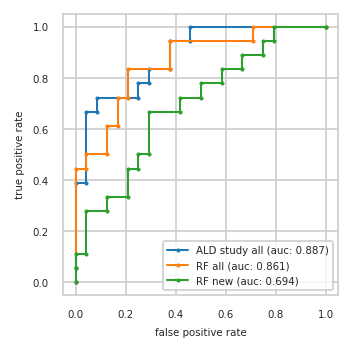

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.389  0.000 0.444  0.000 0.111
3          0.042 0.389  0.042 0.444  0.042 0.111
4          0.042 0.667  0.042 0.500  0.042 0.278
5          0.083 0.667  0.125 0.500  0.125 0.278
6          0.083 0.722  0.125 0.611  0.125 0.333
7          0.250 0.722  0.167 0.611  0.208 0.333
8          0.250 0.778  0.167 0.722  0.208 0.444
9          0.292 0.778  0.208 0.722  0.250 0.444
10         0.292 0.833  0.208 0.833  0.250 0.500
11         0.375 0.833  0.375 0.833  0.292 0.500
12         0.375 0.944  0.375 0.944  0.292 0.667
13         0.458 0.944  0.708 0.944  0.417 0.667
14         0.458 1.000  0.708 1.000  0.417 0.722
15         1.000 1.000  1.000 1.000  0.500 0.722
16           NaN   NaN    NaN   NaN  0.500 0.778
17           NaN   NaN    NaN   NaN  0.583 0.778
18           NaN   NaN    NaN   NaN  0.583 0.833
19           NaN   NaN    NaN   NaN  0.667 0.833
20           NaN   NaN    NaN   NaN  0.667 0.889
21           NaN   NaN    NaN   NaN  0.750 0.889
22           NaN   NaN    NaN   NaN  0.750 0.944
23           NaN   NaN    NaN   NaN  0.792 0.944
24           NaN   NaN    NaN   NaN  0.792 1.000
25           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,Q9NY97;Q9NY97-2,E5RK69;E7EMC6;P08133;P08133-2
2,P09486,P08670,J3KSJ8;Q9UD71;Q9UD71-2
3,K7ERG9;P00746,Q9Y2T3;Q9Y2T3-3,P31150
4,P14174,P08253,Q96GD0
5,P10636-2;P10636-6,P04075,A0A0J9YW36;Q9NZ72;Q9NZ72-2
6,P61981,P14174,P31321
7,Q6EMK4,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,Q9Y2T3;Q9Y2T3-3,Q14894,Q9NUQ9


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


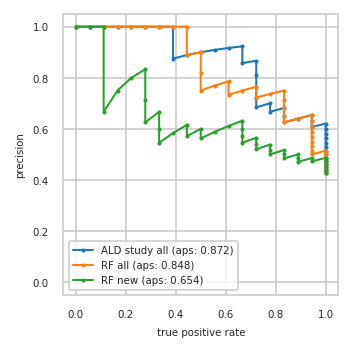

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.500 0.944     0.471 0.889
9          0.545 1.000     0.515 0.944     0.485 0.889
10         0.562 1.000     0.531 0.944     0.500 0.889
11         0.581 1.000     0.548 0.944     0.484 0.833
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.500 0.778
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.654 0.944     0.654 0.944     0.538 0.778
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.625 0.833     0.625 0.833     0.542 0.722
19         0.652 0.833     0.652 0.833     0.565 0.722
20         0.682 0.833     0.682 0.833     0.545 0.667
21         0.667 0.778     0.714 0.833     0.571 0.667
22         0.700 0.778     0.750 0.833     0.600 0.667
23         0.684 0.722     0.737 0.778     0.632 0.667
24         0.722 0.722     0.722 0.722     0.611 0.611
25         0.765 0.722     0.765 0.722     0.588 0.556
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.867 0.722     0.733 0.611     0.600 0.500
28         0.857 0.667     0.786 0.611     0.571 0.444
29         0.923 0.667     0.769 0.556     0.615 0.444
30         0.917 0.611     0.750 0.500     0.583 0.389
31         0.909 0.556     0.818 0.500     0.545 0.333
32         0.900 0.500     0.900 0.500     0.600 0.333
33         0.889 0.444     0.889 0.444     0.667 0.333
34         0.875 0.389     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.833 0.278
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


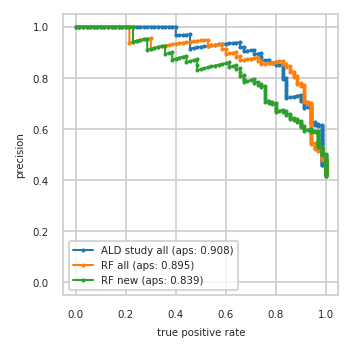

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


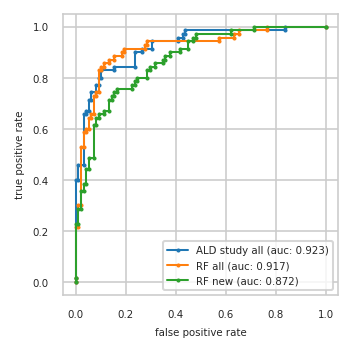

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}